In [145]:
import torch
import torch.utils.data as data
from matplotlib import pyplot as plt
import torchvision
from torch.autograd import Variable
from torchvision import transforms
from torch import nn
import os
import cv2
import numpy as np
from torch.nn import functional as F

In [146]:
root_dir = 'datasets/32x32/images/'
BATCH_SIZE = 64
num_epochs = 400

In [147]:
img_transform = transforms.Compose([
    transforms.ToTensor()])


In [148]:
class IconsDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.filenames = os.listdir(root_dir)
        
    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = os.path.join(self.root_dir, self.filenames[idx])
        image = cv2.imread(filename)
        
        if self.transform:
            image = self.transform(image)

        return image

In [149]:
dataset = IconsDataset(root_dir, transform=img_transform)

In [150]:
loader = data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)

In [178]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.Conv2d(24, 48, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
            nn.ReLU(),
# 			nn.Conv2d(48, 96, 4, stride=2, padding=1),           # [batch, 96, 2, 2]
#             nn.ReLU(),
        )
        self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1),  # [batch, 48, 4, 4]
#             nn.ReLU(),
			nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )
        self.fc_mu = nn.Linear(768,  768)
        self.fc_logvar = nn.Linear(768,  768)
        self.fc_unvectorize = nn.Linear(768, 768)
        
    
    def encode(self, x):
        vector = self.encoder(x)
        vector = vector.view(-1, 768)
        return self.fc_mu(vector), self.fc_logvar(vector)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def decode(self, z):
        h3 = F.relu(self.fc_unvectorize(z))
        h3 = h3.view(-1, 48, 4, 4)
        return self.decoder(h3)
        
        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [179]:
criterion = nn.MSELoss()
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [180]:
model = Autoencoder().cuda()
optimizer = torch.optim.Adam(
    model.parameters(), lr=1e-3)

In [181]:
from tqdm import tqdm
losses = []
for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    for data in loader:
        img = data
        img = Variable(img).cuda()
        img = img.view(-1, 3, 32, 32)
        # ===================forward=====================
        recon_batch, mu, logvar = model(img)
        loss = loss_function(recon_batch, img, mu, logvar)
        total_loss += loss.item()
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    losses.append(total_loss)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, total_loss))









  0%|          | 0/400 [00:00<?, ?it/s]







  0%|          | 1/400 [00:02<15:37,  2.35s/it]

epoch [1/400], loss:19488817.8340










  0%|          | 2/400 [00:04<15:05,  2.28s/it]

epoch [2/400], loss:15703321.4219










  1%|          | 3/400 [00:06<14:46,  2.23s/it]

epoch [3/400], loss:15130398.8770










  1%|          | 4/400 [00:08<14:33,  2.21s/it]

epoch [4/400], loss:14863711.7051










  1%|▏         | 5/400 [00:11<14:54,  2.26s/it]

epoch [5/400], loss:14641117.9824










  2%|▏         | 6/400 [00:13<14:46,  2.25s/it]

epoch [6/400], loss:14485562.1797










  2%|▏         | 7/400 [00:15<14:38,  2.23s/it]

epoch [7/400], loss:14341850.5312










  2%|▏         | 8/400 [00:17<14:40,  2.25s/it]

epoch [8/400], loss:14241329.9668










  2%|▏         | 9/400 [00:20<14:45,  2.27s/it]

epoch [9/400], loss:14134596.3447










  2%|▎         | 10/400 [00:22<15:14,  2.34s/it]

epoch [10/400], loss:14027393.1582










  3%|▎         | 11/400 [00:24<15:03,  2.32s/it]

epoch [11/400], loss:13937287.2598










  3%|▎         | 12/400 [00:27<14:47,  2.29s/it]

epoch [12/400], loss:13848335.4395










  3%|▎         | 13/400 [00:29<14:35,  2.26s/it]

epoch [13/400], loss:13738081.3018










  4%|▎         | 14/400 [00:32<15:29,  2.41s/it]

epoch [14/400], loss:13499653.3008










  4%|▍         | 15/400 [00:34<15:08,  2.36s/it]

epoch [15/400], loss:13331270.2412










  4%|▍         | 16/400 [00:36<15:30,  2.42s/it]

epoch [16/400], loss:13236594.0312










  4%|▍         | 17/400 [00:38<14:49,  2.32s/it]

epoch [17/400], loss:13140787.3340










  4%|▍         | 18/400 [00:41<14:25,  2.27s/it]

epoch [18/400], loss:13062820.6953










  5%|▍         | 19/400 [00:43<14:04,  2.22s/it]

epoch [19/400], loss:12993512.1992










  5%|▌         | 20/400 [00:45<13:51,  2.19s/it]

epoch [20/400], loss:12940092.1934










  5%|▌         | 21/400 [00:47<13:41,  2.17s/it]

epoch [21/400], loss:12892861.1309










  6%|▌         | 22/400 [00:49<13:34,  2.15s/it]

epoch [22/400], loss:12835184.1641










  6%|▌         | 23/400 [00:51<13:43,  2.19s/it]

epoch [23/400], loss:12790152.1895










  6%|▌         | 24/400 [00:54<14:10,  2.26s/it]

epoch [24/400], loss:12755897.9111










  6%|▋         | 25/400 [00:57<15:51,  2.54s/it]

epoch [25/400], loss:12718658.6523










  6%|▋         | 26/400 [00:59<15:15,  2.45s/it]

epoch [26/400], loss:12686668.8506










  7%|▋         | 27/400 [01:02<15:48,  2.54s/it]

epoch [27/400], loss:12657853.0000










  7%|▋         | 28/400 [01:05<16:35,  2.68s/it]

epoch [28/400], loss:12630254.4746










  7%|▋         | 29/400 [01:08<16:19,  2.64s/it]

epoch [29/400], loss:12603091.9277










  8%|▊         | 30/400 [01:11<16:59,  2.75s/it]

epoch [30/400], loss:12579356.6504










  8%|▊         | 31/400 [01:13<16:10,  2.63s/it]

epoch [31/400], loss:12555647.1514










  8%|▊         | 32/400 [01:16<16:40,  2.72s/it]

epoch [32/400], loss:12532549.5879










  8%|▊         | 33/400 [01:19<16:58,  2.77s/it]

epoch [33/400], loss:12510868.0352










  8%|▊         | 34/400 [01:21<15:43,  2.58s/it]

epoch [34/400], loss:12510549.9785










  9%|▉         | 35/400 [01:23<14:49,  2.44s/it]

epoch [35/400], loss:12476174.3330










  9%|▉         | 36/400 [01:25<14:10,  2.34s/it]

epoch [36/400], loss:12462384.4648










  9%|▉         | 37/400 [01:28<15:29,  2.56s/it]

epoch [37/400], loss:12442662.8887










 10%|▉         | 38/400 [01:30<14:36,  2.42s/it]

epoch [38/400], loss:12429582.9404










 10%|▉         | 39/400 [01:33<14:25,  2.40s/it]

epoch [39/400], loss:12419391.2012










 10%|█         | 40/400 [01:35<14:29,  2.42s/it]

epoch [40/400], loss:12393695.7461










 10%|█         | 41/400 [01:37<13:52,  2.32s/it]

epoch [41/400], loss:12389576.3301










 10%|█         | 42/400 [01:39<13:27,  2.26s/it]

epoch [42/400], loss:12374620.3057










 11%|█         | 43/400 [01:41<13:27,  2.26s/it]

epoch [43/400], loss:12356745.0312










 11%|█         | 44/400 [01:44<13:47,  2.33s/it]

epoch [44/400], loss:12349382.5967










 11%|█▏        | 45/400 [01:46<13:58,  2.36s/it]

epoch [45/400], loss:12335214.2217










 12%|█▏        | 46/400 [01:48<13:27,  2.28s/it]

epoch [46/400], loss:12322590.8682










 12%|█▏        | 47/400 [01:51<13:38,  2.32s/it]

epoch [47/400], loss:12319698.6035










 12%|█▏        | 48/400 [01:53<13:51,  2.36s/it]

epoch [48/400], loss:12314615.5254










 12%|█▏        | 49/400 [01:55<13:22,  2.29s/it]

epoch [49/400], loss:12294893.6562










 12%|█▎        | 50/400 [01:58<13:00,  2.23s/it]

epoch [50/400], loss:12286465.5498










 13%|█▎        | 51/400 [02:00<12:43,  2.19s/it]

epoch [51/400], loss:12275190.6748










 13%|█▎        | 52/400 [02:02<12:31,  2.16s/it]

epoch [52/400], loss:12266924.8555










 13%|█▎        | 53/400 [02:04<13:24,  2.32s/it]

epoch [53/400], loss:12262357.3936










 14%|█▎        | 54/400 [02:07<13:40,  2.37s/it]

epoch [54/400], loss:12245970.2178










 14%|█▍        | 55/400 [02:09<13:34,  2.36s/it]

epoch [55/400], loss:12253485.4727










 14%|█▍        | 56/400 [02:11<13:12,  2.30s/it]

epoch [56/400], loss:12244222.4385










 14%|█▍        | 57/400 [02:14<12:55,  2.26s/it]

epoch [57/400], loss:12228027.3252










 14%|█▍        | 58/400 [02:16<12:58,  2.28s/it]

epoch [58/400], loss:12228009.7959










 15%|█▍        | 59/400 [02:19<14:10,  2.49s/it]

epoch [59/400], loss:12208886.8232










 15%|█▌        | 60/400 [02:23<16:04,  2.84s/it]

epoch [60/400], loss:12211915.7383










 15%|█▌        | 61/400 [02:25<16:00,  2.83s/it]

epoch [61/400], loss:12204766.5137










 16%|█▌        | 62/400 [02:28<16:12,  2.88s/it]

epoch [62/400], loss:12200696.6816










 16%|█▌        | 63/400 [02:31<15:32,  2.77s/it]

epoch [63/400], loss:12193026.5898










 16%|█▌        | 64/400 [02:33<14:25,  2.58s/it]

epoch [64/400], loss:12186548.2207










 16%|█▋        | 65/400 [02:35<13:38,  2.44s/it]

epoch [65/400], loss:12185127.2451










 16%|█▋        | 66/400 [02:38<13:33,  2.44s/it]

epoch [66/400], loss:12180109.6299










 17%|█▋        | 67/400 [02:40<12:59,  2.34s/it]

epoch [67/400], loss:12168956.6934










 17%|█▋        | 68/400 [02:42<12:59,  2.35s/it]

epoch [68/400], loss:12165691.1973










 17%|█▋        | 69/400 [02:44<13:00,  2.36s/it]

epoch [69/400], loss:12158750.9395










 18%|█▊        | 70/400 [02:48<14:43,  2.68s/it]

epoch [70/400], loss:12155522.7861










 18%|█▊        | 71/400 [02:51<15:12,  2.77s/it]

epoch [71/400], loss:12154883.6406










 18%|█▊        | 72/400 [02:54<16:35,  3.04s/it]

epoch [72/400], loss:12151018.5557










 18%|█▊        | 73/400 [02:57<15:21,  2.82s/it]

epoch [73/400], loss:12146422.2939










 18%|█▊        | 74/400 [02:59<14:15,  2.62s/it]

epoch [74/400], loss:12136851.6211










 19%|█▉        | 75/400 [03:01<13:24,  2.47s/it]

epoch [75/400], loss:12139717.9775










 19%|█▉        | 76/400 [03:03<12:47,  2.37s/it]

epoch [76/400], loss:12130346.3359










 19%|█▉        | 77/400 [03:05<12:22,  2.30s/it]

epoch [77/400], loss:12127585.9004










 20%|█▉        | 78/400 [03:07<11:59,  2.24s/it]

epoch [78/400], loss:12119695.9756










 20%|█▉        | 79/400 [03:10<11:44,  2.19s/it]

epoch [79/400], loss:12117587.4512










 20%|██        | 80/400 [03:12<11:33,  2.17s/it]

epoch [80/400], loss:12117397.9834










 20%|██        | 81/400 [03:14<11:25,  2.15s/it]

epoch [81/400], loss:12111722.8594










 20%|██        | 82/400 [03:16<11:19,  2.14s/it]

epoch [82/400], loss:12117312.2246










 21%|██        | 83/400 [03:19<12:40,  2.40s/it]

epoch [83/400], loss:12106825.5762










 21%|██        | 84/400 [03:22<13:37,  2.59s/it]

epoch [84/400], loss:12102586.4990










 21%|██▏       | 85/400 [03:24<13:16,  2.53s/it]

epoch [85/400], loss:12099607.5850










 22%|██▏       | 86/400 [03:27<13:56,  2.66s/it]

epoch [86/400], loss:12094439.5498










 22%|██▏       | 87/400 [03:30<14:44,  2.82s/it]

epoch [87/400], loss:12086258.0908










 22%|██▏       | 88/400 [03:33<13:57,  2.68s/it]

epoch [88/400], loss:12085498.8037










 22%|██▏       | 89/400 [03:35<13:07,  2.53s/it]

epoch [89/400], loss:12082896.1113










 22%|██▎       | 90/400 [03:38<13:52,  2.68s/it]

epoch [90/400], loss:12078426.1270










 23%|██▎       | 91/400 [03:41<14:59,  2.91s/it]

epoch [91/400], loss:12082208.0498










 23%|██▎       | 92/400 [03:45<16:03,  3.13s/it]

epoch [92/400], loss:12077409.4912










 23%|██▎       | 93/400 [03:48<14:53,  2.91s/it]

epoch [93/400], loss:12073797.4668










 24%|██▎       | 94/400 [03:50<13:37,  2.67s/it]

epoch [94/400], loss:12071161.7344










 24%|██▍       | 95/400 [03:52<12:59,  2.56s/it]

epoch [95/400], loss:12065403.7656










 24%|██▍       | 96/400 [03:54<12:17,  2.43s/it]

epoch [96/400], loss:12069076.7383










 24%|██▍       | 97/400 [03:56<11:50,  2.34s/it]

epoch [97/400], loss:12061385.9824










 24%|██▍       | 98/400 [03:58<11:29,  2.28s/it]

epoch [98/400], loss:12054626.4980










 25%|██▍       | 99/400 [04:00<11:12,  2.23s/it]

epoch [99/400], loss:12057235.5117










 25%|██▌       | 100/400 [04:03<10:59,  2.20s/it]

epoch [100/400], loss:12050216.8066










 25%|██▌       | 101/400 [04:05<10:49,  2.17s/it]

epoch [101/400], loss:12052583.0703










 26%|██▌       | 102/400 [04:07<10:42,  2.15s/it]

epoch [102/400], loss:12055298.6357










 26%|██▌       | 103/400 [04:09<10:38,  2.15s/it]

epoch [103/400], loss:12043973.1797










 26%|██▌       | 104/400 [04:11<10:33,  2.14s/it]

epoch [104/400], loss:12041881.0400










 26%|██▋       | 105/400 [04:13<10:29,  2.13s/it]

epoch [105/400], loss:12039566.1309










 26%|██▋       | 106/400 [04:15<10:25,  2.13s/it]

epoch [106/400], loss:12038862.5771










 27%|██▋       | 107/400 [04:17<10:21,  2.12s/it]

epoch [107/400], loss:12037705.4004










 27%|██▋       | 108/400 [04:20<10:17,  2.12s/it]

epoch [108/400], loss:12033818.7031










 27%|██▋       | 109/400 [04:22<10:14,  2.11s/it]

epoch [109/400], loss:12033255.7490










 28%|██▊       | 110/400 [04:24<10:13,  2.11s/it]

epoch [110/400], loss:12029372.1562










 28%|██▊       | 111/400 [04:26<10:10,  2.11s/it]

epoch [111/400], loss:12027095.2881










 28%|██▊       | 112/400 [04:28<10:08,  2.11s/it]

epoch [112/400], loss:12026856.4473










 28%|██▊       | 113/400 [04:30<10:05,  2.11s/it]

epoch [113/400], loss:12022586.4385










 28%|██▊       | 114/400 [04:32<10:05,  2.12s/it]

epoch [114/400], loss:12017903.5957










 29%|██▉       | 115/400 [04:34<10:02,  2.11s/it]

epoch [115/400], loss:12020375.4766










 29%|██▉       | 116/400 [04:36<09:59,  2.11s/it]

epoch [116/400], loss:12015445.2471










 29%|██▉       | 117/400 [04:39<09:57,  2.11s/it]

epoch [117/400], loss:12011787.9834










 30%|██▉       | 118/400 [04:41<09:54,  2.11s/it]

epoch [118/400], loss:12009308.5596










 30%|██▉       | 119/400 [04:43<10:04,  2.15s/it]

epoch [119/400], loss:12009877.5527










 30%|███       | 120/400 [04:45<10:14,  2.20s/it]

epoch [120/400], loss:12001877.2275










 30%|███       | 121/400 [04:48<10:26,  2.25s/it]

epoch [121/400], loss:12005587.8984










 30%|███       | 122/400 [04:50<10:34,  2.28s/it]

epoch [122/400], loss:11998877.0547










 31%|███       | 123/400 [04:52<10:43,  2.32s/it]

epoch [123/400], loss:12001668.5303










 31%|███       | 124/400 [04:55<11:04,  2.41s/it]

epoch [124/400], loss:12001895.7295










 31%|███▏      | 125/400 [04:57<11:02,  2.41s/it]

epoch [125/400], loss:11995973.5684










 32%|███▏      | 126/400 [04:59<10:40,  2.34s/it]

epoch [126/400], loss:11993347.3457










 32%|███▏      | 127/400 [05:02<10:33,  2.32s/it]

epoch [127/400], loss:11992489.7695










 32%|███▏      | 128/400 [05:04<10:14,  2.26s/it]

epoch [128/400], loss:11992313.9150










 32%|███▏      | 129/400 [05:06<10:06,  2.24s/it]

epoch [129/400], loss:11999293.1172










 32%|███▎      | 130/400 [05:08<09:51,  2.19s/it]

epoch [130/400], loss:11983543.5146










 33%|███▎      | 131/400 [05:10<09:42,  2.17s/it]

epoch [131/400], loss:11991402.1006










 33%|███▎      | 132/400 [05:12<09:37,  2.15s/it]

epoch [132/400], loss:11985939.9248










 33%|███▎      | 133/400 [05:14<09:29,  2.13s/it]

epoch [133/400], loss:11983172.1846










 34%|███▎      | 134/400 [05:17<09:24,  2.12s/it]

epoch [134/400], loss:11981225.8398










 34%|███▍      | 135/400 [05:19<09:22,  2.12s/it]

epoch [135/400], loss:11977325.7148










 34%|███▍      | 136/400 [05:21<09:31,  2.17s/it]

epoch [136/400], loss:11984179.2969










 34%|███▍      | 137/400 [05:23<09:44,  2.22s/it]

epoch [137/400], loss:11975940.7070










 34%|███▍      | 138/400 [05:26<09:57,  2.28s/it]

epoch [138/400], loss:11970469.5742










 35%|███▍      | 139/400 [05:28<09:58,  2.29s/it]

epoch [139/400], loss:11973073.6699










 35%|███▌      | 140/400 [05:30<10:04,  2.33s/it]

epoch [140/400], loss:11971919.7100










 35%|███▌      | 141/400 [05:33<10:02,  2.33s/it]

epoch [141/400], loss:11962854.8896










 36%|███▌      | 142/400 [05:35<09:56,  2.31s/it]

epoch [142/400], loss:11968112.6055










 36%|███▌      | 143/400 [05:37<09:46,  2.28s/it]

epoch [143/400], loss:11968233.4580










 36%|███▌      | 144/400 [05:39<09:35,  2.25s/it]

epoch [144/400], loss:11966147.5820










 36%|███▋      | 145/400 [05:42<09:23,  2.21s/it]

epoch [145/400], loss:11965112.3965










 36%|███▋      | 146/400 [05:44<09:12,  2.18s/it]

epoch [146/400], loss:11963277.3398










 37%|███▋      | 147/400 [05:46<09:03,  2.15s/it]

epoch [147/400], loss:11959314.3252










 37%|███▋      | 148/400 [05:48<08:59,  2.14s/it]

epoch [148/400], loss:11966507.5977










 37%|███▋      | 149/400 [05:50<08:55,  2.13s/it]

epoch [149/400], loss:11957920.5146










 38%|███▊      | 150/400 [05:52<08:51,  2.12s/it]

epoch [150/400], loss:11956393.1240










 38%|███▊      | 151/400 [05:54<08:47,  2.12s/it]

epoch [151/400], loss:11952503.9434










 38%|███▊      | 152/400 [05:56<08:55,  2.16s/it]

epoch [152/400], loss:11957382.7070










 38%|███▊      | 153/400 [05:59<08:55,  2.17s/it]

epoch [153/400], loss:11950973.7109










 38%|███▊      | 154/400 [06:01<08:59,  2.19s/it]

epoch [154/400], loss:11948062.8516










 39%|███▉      | 155/400 [06:03<08:58,  2.20s/it]

epoch [155/400], loss:11955233.6084










 39%|███▉      | 156/400 [06:05<08:54,  2.19s/it]

epoch [156/400], loss:11951727.8545










 39%|███▉      | 157/400 [06:07<08:46,  2.17s/it]

epoch [157/400], loss:11951138.5195










 40%|███▉      | 158/400 [06:10<08:47,  2.18s/it]

epoch [158/400], loss:11944193.7070










 40%|███▉      | 159/400 [06:12<08:56,  2.22s/it]

epoch [159/400], loss:11939335.1816










 40%|████      | 160/400 [06:14<09:08,  2.29s/it]

epoch [160/400], loss:11940574.3770










 40%|████      | 161/400 [06:17<09:13,  2.32s/it]

epoch [161/400], loss:11944623.1250










 40%|████      | 162/400 [06:19<09:19,  2.35s/it]

epoch [162/400], loss:11935577.3066










 41%|████      | 163/400 [06:22<09:34,  2.42s/it]

epoch [163/400], loss:11938719.0166










 41%|████      | 164/400 [06:24<09:18,  2.37s/it]

epoch [164/400], loss:11937249.2998










 41%|████▏     | 165/400 [06:26<08:57,  2.29s/it]

epoch [165/400], loss:11939142.7803










 42%|████▏     | 166/400 [06:28<08:43,  2.24s/it]

epoch [166/400], loss:11942966.5410










 42%|████▏     | 167/400 [06:30<08:33,  2.21s/it]

epoch [167/400], loss:11935855.4268










 42%|████▏     | 168/400 [06:32<08:25,  2.18s/it]

epoch [168/400], loss:11934912.7080










 42%|████▏     | 169/400 [06:35<08:17,  2.15s/it]

epoch [169/400], loss:11934522.5156










 42%|████▎     | 170/400 [06:37<08:12,  2.14s/it]

epoch [170/400], loss:11934621.0840










 43%|████▎     | 171/400 [06:39<08:08,  2.13s/it]

epoch [171/400], loss:11930128.0713










 43%|████▎     | 172/400 [06:41<08:04,  2.13s/it]

epoch [172/400], loss:11929034.9443










 43%|████▎     | 173/400 [06:43<08:04,  2.14s/it]

epoch [173/400], loss:11931193.0312










 44%|████▎     | 174/400 [06:45<07:59,  2.12s/it]

epoch [174/400], loss:11924847.3320










 44%|████▍     | 175/400 [06:47<07:55,  2.11s/it]

epoch [175/400], loss:11931744.1123










 44%|████▍     | 176/400 [06:49<07:53,  2.11s/it]

epoch [176/400], loss:11931140.0615










 44%|████▍     | 177/400 [06:51<07:51,  2.11s/it]

epoch [177/400], loss:11924190.5146










 44%|████▍     | 178/400 [06:54<07:48,  2.11s/it]

epoch [178/400], loss:11921977.9102










 45%|████▍     | 179/400 [06:56<07:47,  2.11s/it]

epoch [179/400], loss:11919942.6240










 45%|████▌     | 180/400 [06:58<07:44,  2.11s/it]

epoch [180/400], loss:11921604.3701










 45%|████▌     | 181/400 [07:00<07:42,  2.11s/it]

epoch [181/400], loss:11918629.5098










 46%|████▌     | 182/400 [07:02<07:40,  2.11s/it]

epoch [182/400], loss:11915863.2148










 46%|████▌     | 183/400 [07:04<07:38,  2.11s/it]

epoch [183/400], loss:11918144.8711










 46%|████▌     | 184/400 [07:06<07:36,  2.11s/it]

epoch [184/400], loss:11916864.9297










 46%|████▋     | 185/400 [07:08<07:34,  2.11s/it]

epoch [185/400], loss:11921953.4609










 46%|████▋     | 186/400 [07:10<07:32,  2.11s/it]

epoch [186/400], loss:11917057.2305










 47%|████▋     | 187/400 [07:13<07:33,  2.13s/it]

epoch [187/400], loss:11914858.4326










 47%|████▋     | 188/400 [07:15<07:37,  2.16s/it]

epoch [188/400], loss:11919395.2256










 47%|████▋     | 189/400 [07:17<07:31,  2.14s/it]

epoch [189/400], loss:11909304.5449










 48%|████▊     | 190/400 [07:19<07:28,  2.13s/it]

epoch [190/400], loss:11909681.9727










 48%|████▊     | 191/400 [07:21<07:33,  2.17s/it]

epoch [191/400], loss:11910364.7695










 48%|████▊     | 192/400 [07:24<07:56,  2.29s/it]

epoch [192/400], loss:11903543.6855










 48%|████▊     | 193/400 [07:26<07:58,  2.31s/it]

epoch [193/400], loss:11911113.1016










 48%|████▊     | 194/400 [07:29<08:15,  2.41s/it]

epoch [194/400], loss:11909064.7480










 49%|████▉     | 195/400 [07:31<08:11,  2.40s/it]

epoch [195/400], loss:11904158.3184










 49%|████▉     | 196/400 [07:34<08:29,  2.50s/it]

epoch [196/400], loss:11905681.3896










 49%|████▉     | 197/400 [07:36<08:21,  2.47s/it]

epoch [197/400], loss:11907963.8574










 50%|████▉     | 198/400 [07:39<07:57,  2.37s/it]

epoch [198/400], loss:11902374.4590










 50%|████▉     | 199/400 [07:41<07:41,  2.30s/it]

epoch [199/400], loss:11905790.8896










 50%|█████     | 200/400 [07:43<07:32,  2.26s/it]

epoch [200/400], loss:11904988.8115










 50%|█████     | 201/400 [07:46<08:21,  2.52s/it]

epoch [201/400], loss:11897914.0361










 50%|█████     | 202/400 [07:50<09:27,  2.87s/it]

epoch [202/400], loss:11898714.5254










 51%|█████     | 203/400 [07:52<09:11,  2.80s/it]

epoch [203/400], loss:11902088.0947










 51%|█████     | 204/400 [07:55<08:47,  2.69s/it]

epoch [204/400], loss:11900191.9453










 51%|█████▏    | 205/400 [07:57<08:31,  2.62s/it]

epoch [205/400], loss:11896714.1152










 52%|█████▏    | 206/400 [08:00<08:42,  2.69s/it]

epoch [206/400], loss:11901533.4971










 52%|█████▏    | 207/400 [08:03<08:32,  2.65s/it]

epoch [207/400], loss:11897289.4951










 52%|█████▏    | 208/400 [08:05<08:16,  2.59s/it]

epoch [208/400], loss:11895947.8096










 52%|█████▏    | 209/400 [08:07<07:52,  2.48s/it]

epoch [209/400], loss:11903993.6279










 52%|█████▎    | 210/400 [08:09<07:34,  2.39s/it]

epoch [210/400], loss:11895923.6211










 53%|█████▎    | 211/400 [08:12<08:00,  2.54s/it]

epoch [211/400], loss:11890961.5195










 53%|█████▎    | 212/400 [08:17<09:39,  3.08s/it]

epoch [212/400], loss:11898101.2393










 53%|█████▎    | 213/400 [08:19<08:43,  2.80s/it]

epoch [213/400], loss:11892733.7314










 54%|█████▎    | 214/400 [08:21<08:03,  2.60s/it]

epoch [214/400], loss:11896553.1328










 54%|█████▍    | 215/400 [08:23<07:33,  2.45s/it]

epoch [215/400], loss:11898689.8662










 54%|█████▍    | 216/400 [08:25<07:23,  2.41s/it]

epoch [216/400], loss:11887593.0312










 54%|█████▍    | 217/400 [08:28<07:11,  2.36s/it]

epoch [217/400], loss:11890236.4580










 55%|█████▍    | 218/400 [08:30<06:55,  2.29s/it]

epoch [218/400], loss:11888094.0342










 55%|█████▍    | 219/400 [08:32<06:47,  2.25s/it]

epoch [219/400], loss:11889828.6016










 55%|█████▌    | 220/400 [08:34<06:37,  2.21s/it]

epoch [220/400], loss:11884314.9785










 55%|█████▌    | 221/400 [08:36<06:29,  2.18s/it]

epoch [221/400], loss:11887191.3037










 56%|█████▌    | 222/400 [08:38<06:25,  2.17s/it]

epoch [222/400], loss:11884451.0703










 56%|█████▌    | 223/400 [08:40<06:20,  2.15s/it]

epoch [223/400], loss:11883114.0566










 56%|█████▌    | 224/400 [08:43<06:18,  2.15s/it]

epoch [224/400], loss:11883477.3848










 56%|█████▋    | 225/400 [08:45<06:14,  2.14s/it]

epoch [225/400], loss:11884505.8086










 56%|█████▋    | 226/400 [08:47<06:11,  2.13s/it]

epoch [226/400], loss:11885284.0791










 57%|█████▋    | 227/400 [08:49<06:08,  2.13s/it]

epoch [227/400], loss:11884568.0537










 57%|█████▋    | 228/400 [08:51<06:05,  2.13s/it]

epoch [228/400], loss:11891964.8701










 57%|█████▋    | 229/400 [08:53<06:03,  2.13s/it]

epoch [229/400], loss:11883856.0830










 57%|█████▊    | 230/400 [08:55<06:00,  2.12s/it]

epoch [230/400], loss:11877768.1504










 58%|█████▊    | 231/400 [08:57<06:01,  2.14s/it]

epoch [231/400], loss:11877940.6094










 58%|█████▊    | 232/400 [09:00<06:09,  2.20s/it]

epoch [232/400], loss:11881913.6699










 58%|█████▊    | 233/400 [09:02<06:26,  2.31s/it]

epoch [233/400], loss:11873412.4541










 58%|█████▊    | 234/400 [09:05<06:22,  2.31s/it]

epoch [234/400], loss:11882549.0703










 59%|█████▉    | 235/400 [09:07<06:20,  2.30s/it]

epoch [235/400], loss:11874658.6748










 59%|█████▉    | 236/400 [09:09<06:18,  2.31s/it]

epoch [236/400], loss:11870123.7588










 59%|█████▉    | 237/400 [09:11<06:08,  2.26s/it]

epoch [237/400], loss:11868535.7393










 60%|█████▉    | 238/400 [09:14<05:59,  2.22s/it]

epoch [238/400], loss:11865163.8105










 60%|█████▉    | 239/400 [09:16<06:13,  2.32s/it]

epoch [239/400], loss:11859289.8115










 60%|██████    | 240/400 [09:18<06:09,  2.31s/it]

epoch [240/400], loss:11855818.2803










 60%|██████    | 241/400 [09:21<06:04,  2.30s/it]

epoch [241/400], loss:11858134.3057










 60%|██████    | 242/400 [09:23<05:54,  2.24s/it]

epoch [242/400], loss:11853003.7793










 61%|██████    | 243/400 [09:25<05:46,  2.20s/it]

epoch [243/400], loss:11851403.7256










 61%|██████    | 244/400 [09:27<05:40,  2.18s/it]

epoch [244/400], loss:11852112.3242










 61%|██████▏   | 245/400 [09:29<05:34,  2.16s/it]

epoch [245/400], loss:11850568.7441










 62%|██████▏   | 246/400 [09:31<05:30,  2.14s/it]

epoch [246/400], loss:11840053.1748










 62%|██████▏   | 247/400 [09:33<05:26,  2.13s/it]

epoch [247/400], loss:11846709.0234










 62%|██████▏   | 248/400 [09:35<05:23,  2.13s/it]

epoch [248/400], loss:11845588.8984










 62%|██████▏   | 249/400 [09:38<05:24,  2.15s/it]

epoch [249/400], loss:11838606.2676










 62%|██████▎   | 250/400 [09:40<05:28,  2.19s/it]

epoch [250/400], loss:11845939.3438










 63%|██████▎   | 251/400 [09:42<05:26,  2.19s/it]

epoch [251/400], loss:11840900.4541










 63%|██████▎   | 252/400 [09:44<05:32,  2.25s/it]

epoch [252/400], loss:11847831.8340










 63%|██████▎   | 253/400 [09:47<05:35,  2.28s/it]

epoch [253/400], loss:11834394.0322










 64%|██████▎   | 254/400 [09:49<05:32,  2.28s/it]

epoch [254/400], loss:11835541.2412










 64%|██████▍   | 255/400 [09:51<05:28,  2.27s/it]

epoch [255/400], loss:11834397.0283










 64%|██████▍   | 256/400 [09:54<05:21,  2.23s/it]

epoch [256/400], loss:11832981.0928










 64%|██████▍   | 257/400 [09:56<05:14,  2.20s/it]

epoch [257/400], loss:11836680.1963










 64%|██████▍   | 258/400 [09:58<05:14,  2.22s/it]

epoch [258/400], loss:11836361.2051










 65%|██████▍   | 259/400 [10:00<05:11,  2.21s/it]

epoch [259/400], loss:11829289.1719










 65%|██████▌   | 260/400 [10:02<05:10,  2.22s/it]

epoch [260/400], loss:11831118.3018










 65%|██████▌   | 261/400 [10:04<05:03,  2.18s/it]

epoch [261/400], loss:11828329.6992










 66%|██████▌   | 262/400 [10:07<04:59,  2.17s/it]

epoch [262/400], loss:11836305.2061










 66%|██████▌   | 263/400 [10:09<04:56,  2.16s/it]

epoch [263/400], loss:11826275.7539










 66%|██████▌   | 264/400 [10:11<04:53,  2.16s/it]

epoch [264/400], loss:11826728.7832










 66%|██████▋   | 265/400 [10:13<04:50,  2.15s/it]

epoch [265/400], loss:11824468.1895










 66%|██████▋   | 266/400 [10:15<04:51,  2.17s/it]

epoch [266/400], loss:11827672.5947










 67%|██████▋   | 267/400 [10:18<04:57,  2.24s/it]

epoch [267/400], loss:11823034.5234










 67%|██████▋   | 268/400 [10:20<04:59,  2.27s/it]

epoch [268/400], loss:11819862.6064










 67%|██████▋   | 269/400 [10:22<05:02,  2.31s/it]

epoch [269/400], loss:11819682.7803










 68%|██████▊   | 270/400 [10:25<04:54,  2.26s/it]

epoch [270/400], loss:11822196.2764










 68%|██████▊   | 271/400 [10:27<04:50,  2.25s/it]

epoch [271/400], loss:11822733.1768










 68%|██████▊   | 272/400 [10:29<04:43,  2.21s/it]

epoch [272/400], loss:11821105.5625










 68%|██████▊   | 273/400 [10:31<04:37,  2.19s/it]

epoch [273/400], loss:11818118.7676










 68%|██████▊   | 274/400 [10:33<04:33,  2.17s/it]

epoch [274/400], loss:11819391.2998










 69%|██████▉   | 275/400 [10:35<04:28,  2.15s/it]

epoch [275/400], loss:11820762.3428










 69%|██████▉   | 276/400 [10:37<04:24,  2.14s/it]

epoch [276/400], loss:11816259.5791










 69%|██████▉   | 277/400 [10:40<04:37,  2.25s/it]

epoch [277/400], loss:11822468.8398










 70%|██████▉   | 278/400 [10:42<04:39,  2.29s/it]

epoch [278/400], loss:11814843.2227










 70%|██████▉   | 279/400 [10:45<04:39,  2.31s/it]

epoch [279/400], loss:11818631.4150










 70%|███████   | 280/400 [10:47<04:34,  2.29s/it]

epoch [280/400], loss:11813963.7793










 70%|███████   | 281/400 [10:49<04:42,  2.38s/it]

epoch [281/400], loss:11809930.4258










 70%|███████   | 282/400 [10:52<04:54,  2.49s/it]

epoch [282/400], loss:11812550.2705










 71%|███████   | 283/400 [10:55<05:12,  2.67s/it]

epoch [283/400], loss:11811044.6104










 71%|███████   | 284/400 [10:58<04:57,  2.57s/it]

epoch [284/400], loss:11815829.7852










 71%|███████▏  | 285/400 [11:00<04:43,  2.46s/it]

epoch [285/400], loss:11811334.4727










 72%|███████▏  | 286/400 [11:03<04:50,  2.55s/it]

epoch [286/400], loss:11814476.8359










 72%|███████▏  | 287/400 [11:05<04:58,  2.64s/it]

epoch [287/400], loss:11813978.0273










 72%|███████▏  | 288/400 [11:08<04:45,  2.55s/it]

epoch [288/400], loss:11804421.8711










 72%|███████▏  | 289/400 [11:10<04:30,  2.44s/it]

epoch [289/400], loss:11808773.5342










 72%|███████▎  | 290/400 [11:12<04:21,  2.38s/it]

epoch [290/400], loss:11809479.2227










 73%|███████▎  | 291/400 [11:14<04:09,  2.29s/it]

epoch [291/400], loss:11812233.0059










 73%|███████▎  | 292/400 [11:16<04:00,  2.23s/it]

epoch [292/400], loss:11805650.0371










 73%|███████▎  | 293/400 [11:18<03:55,  2.20s/it]

epoch [293/400], loss:11802914.2480










 74%|███████▎  | 294/400 [11:21<03:59,  2.26s/it]

epoch [294/400], loss:11804074.4648










 74%|███████▍  | 295/400 [11:23<03:57,  2.26s/it]

epoch [295/400], loss:11804385.5977










 74%|███████▍  | 296/400 [11:25<03:52,  2.23s/it]

epoch [296/400], loss:11803750.7363










 74%|███████▍  | 297/400 [11:27<03:47,  2.21s/it]

epoch [297/400], loss:11802189.7031










 74%|███████▍  | 298/400 [11:30<03:43,  2.19s/it]

epoch [298/400], loss:11802596.9482










 75%|███████▍  | 299/400 [11:32<03:39,  2.17s/it]

epoch [299/400], loss:11798638.7363










 75%|███████▌  | 300/400 [11:35<03:57,  2.37s/it]

epoch [300/400], loss:11799335.8438










 75%|███████▌  | 301/400 [11:37<04:03,  2.46s/it]

epoch [301/400], loss:11800657.3301










 76%|███████▌  | 302/400 [11:41<04:25,  2.71s/it]

epoch [302/400], loss:11802283.7109










 76%|███████▌  | 303/400 [11:43<04:21,  2.70s/it]

epoch [303/400], loss:11799530.5693










 76%|███████▌  | 304/400 [11:45<04:03,  2.54s/it]

epoch [304/400], loss:11799064.4453










 76%|███████▋  | 305/400 [11:47<03:50,  2.43s/it]

epoch [305/400], loss:11799296.6621










 76%|███████▋  | 306/400 [11:50<03:56,  2.52s/it]

epoch [306/400], loss:11797799.4668










 77%|███████▋  | 307/400 [11:53<04:03,  2.62s/it]

epoch [307/400], loss:11801439.9131










 77%|███████▋  | 308/400 [11:56<04:06,  2.68s/it]

epoch [308/400], loss:11794458.4844










 77%|███████▋  | 309/400 [11:58<03:47,  2.50s/it]

epoch [309/400], loss:11799372.2637










 78%|███████▊  | 310/400 [12:00<03:34,  2.38s/it]

epoch [310/400], loss:11796491.6768










 78%|███████▊  | 311/400 [12:02<03:24,  2.30s/it]

epoch [311/400], loss:11797844.4668










 78%|███████▊  | 312/400 [12:05<03:24,  2.32s/it]

epoch [312/400], loss:11791951.6621










 78%|███████▊  | 313/400 [12:07<03:29,  2.41s/it]

epoch [313/400], loss:11792743.8428










 78%|███████▊  | 314/400 [12:10<03:28,  2.42s/it]

epoch [314/400], loss:11791311.8623










 79%|███████▉  | 315/400 [12:12<03:26,  2.43s/it]

epoch [315/400], loss:11792720.6455










 79%|███████▉  | 316/400 [12:15<03:34,  2.55s/it]

epoch [316/400], loss:11792333.9453










 79%|███████▉  | 317/400 [12:17<03:22,  2.44s/it]

epoch [317/400], loss:11787937.2686










 80%|███████▉  | 318/400 [12:19<03:15,  2.38s/it]

epoch [318/400], loss:11788445.4395










 80%|███████▉  | 319/400 [12:21<03:07,  2.31s/it]

epoch [319/400], loss:11793252.1855










 80%|████████  | 320/400 [12:24<02:59,  2.25s/it]

epoch [320/400], loss:11786304.6855










 80%|████████  | 321/400 [12:26<03:00,  2.29s/it]

epoch [321/400], loss:11789277.5010










 80%|████████  | 322/400 [12:28<02:54,  2.23s/it]

epoch [322/400], loss:11787184.3145










 81%|████████  | 323/400 [12:31<03:04,  2.40s/it]

epoch [323/400], loss:11789934.3389










 81%|████████  | 324/400 [12:34<03:24,  2.69s/it]

epoch [324/400], loss:11789085.2363










 81%|████████▏ | 325/400 [12:36<03:10,  2.54s/it]

epoch [325/400], loss:11794354.4463










 82%|████████▏ | 326/400 [12:39<03:00,  2.43s/it]

epoch [326/400], loss:11786662.3428










 82%|████████▏ | 327/400 [12:41<02:51,  2.35s/it]

epoch [327/400], loss:11785898.7607










 82%|████████▏ | 328/400 [12:43<02:45,  2.30s/it]

epoch [328/400], loss:11786531.2314










 82%|████████▏ | 329/400 [12:45<02:46,  2.34s/it]

epoch [329/400], loss:11779977.6846










 82%|████████▎ | 330/400 [12:48<02:49,  2.42s/it]

epoch [330/400], loss:11781732.3623










 83%|████████▎ | 331/400 [12:51<02:52,  2.50s/it]

epoch [331/400], loss:11788189.2959










 83%|████████▎ | 332/400 [12:54<03:03,  2.69s/it]

epoch [332/400], loss:11780592.8887










 83%|████████▎ | 333/400 [12:56<02:57,  2.65s/it]

epoch [333/400], loss:11788614.8262










 84%|████████▎ | 334/400 [13:00<03:11,  2.90s/it]

epoch [334/400], loss:11780937.4141










 84%|████████▍ | 335/400 [13:03<03:04,  2.83s/it]

epoch [335/400], loss:11780083.2744










 84%|████████▍ | 336/400 [13:05<02:54,  2.73s/it]

epoch [336/400], loss:11780494.6484










 84%|████████▍ | 337/400 [13:08<03:05,  2.95s/it]

epoch [337/400], loss:11783486.1699










 84%|████████▍ | 338/400 [13:11<03:02,  2.95s/it]

epoch [338/400], loss:11777798.4355










 85%|████████▍ | 339/400 [13:14<02:47,  2.74s/it]

epoch [339/400], loss:11779188.2676










 85%|████████▌ | 340/400 [13:17<02:56,  2.93s/it]

epoch [340/400], loss:11781882.6768










 85%|████████▌ | 341/400 [13:19<02:40,  2.73s/it]

epoch [341/400], loss:11777883.2666










 86%|████████▌ | 342/400 [13:21<02:27,  2.54s/it]

epoch [342/400], loss:11774781.8467










 86%|████████▌ | 343/400 [13:24<02:19,  2.45s/it]

epoch [343/400], loss:11777318.4639










 86%|████████▌ | 344/400 [13:26<02:14,  2.40s/it]

epoch [344/400], loss:11781801.8936










 86%|████████▋ | 345/400 [13:28<02:08,  2.34s/it]

epoch [345/400], loss:11780861.9834










 86%|████████▋ | 346/400 [13:30<02:02,  2.28s/it]

epoch [346/400], loss:11776653.1377










 87%|████████▋ | 347/400 [13:32<01:58,  2.24s/it]

epoch [347/400], loss:11778034.4482










 87%|████████▋ | 348/400 [13:35<01:54,  2.20s/it]

epoch [348/400], loss:11775194.0801










 87%|████████▋ | 349/400 [13:37<01:54,  2.25s/it]

epoch [349/400], loss:11772803.4834










 88%|████████▊ | 350/400 [13:39<01:56,  2.32s/it]

epoch [350/400], loss:11776769.6221










 88%|████████▊ | 351/400 [13:42<02:00,  2.46s/it]

epoch [351/400], loss:11775851.2490










 88%|████████▊ | 352/400 [13:45<02:06,  2.65s/it]

epoch [352/400], loss:11770318.1875










 88%|████████▊ | 353/400 [13:49<02:23,  3.05s/it]

epoch [353/400], loss:11770868.8760










 88%|████████▊ | 354/400 [13:52<02:18,  3.01s/it]

epoch [354/400], loss:11778776.2637










 89%|████████▉ | 355/400 [13:55<02:13,  2.97s/it]

epoch [355/400], loss:11768613.9277










 89%|████████▉ | 356/400 [13:58<02:07,  2.91s/it]

epoch [356/400], loss:11774911.4033










 89%|████████▉ | 357/400 [14:00<01:54,  2.67s/it]

epoch [357/400], loss:11774788.2588










 90%|████████▉ | 358/400 [14:02<01:45,  2.50s/it]

epoch [358/400], loss:11769550.0244










 90%|████████▉ | 359/400 [14:04<01:37,  2.39s/it]

epoch [359/400], loss:11771404.4053










 90%|█████████ | 360/400 [14:07<01:37,  2.43s/it]

epoch [360/400], loss:11771932.5908










 90%|█████████ | 361/400 [14:09<01:31,  2.33s/it]

epoch [361/400], loss:11769696.9854










 90%|█████████ | 362/400 [14:11<01:26,  2.26s/it]

epoch [362/400], loss:11771646.5518










 91%|█████████ | 363/400 [14:13<01:22,  2.22s/it]

epoch [363/400], loss:11769939.2656










 91%|█████████ | 364/400 [14:15<01:21,  2.28s/it]

epoch [364/400], loss:11770013.7549










 91%|█████████▏| 365/400 [14:18<01:26,  2.49s/it]

epoch [365/400], loss:11767477.5674










 92%|█████████▏| 366/400 [14:20<01:20,  2.38s/it]

epoch [366/400], loss:11766254.6904










 92%|█████████▏| 367/400 [14:23<01:20,  2.45s/it]

epoch [367/400], loss:11766715.1875










 92%|█████████▏| 368/400 [14:25<01:17,  2.42s/it]

epoch [368/400], loss:11765832.2783










 92%|█████████▏| 369/400 [14:29<01:23,  2.68s/it]

epoch [369/400], loss:11765903.1953










 92%|█████████▎| 370/400 [14:33<01:33,  3.11s/it]

epoch [370/400], loss:11768248.6533










 93%|█████████▎| 371/400 [14:36<01:29,  3.10s/it]

epoch [371/400], loss:11767833.7480










 93%|█████████▎| 372/400 [14:38<01:18,  2.81s/it]

epoch [372/400], loss:11766152.8232










 93%|█████████▎| 373/400 [14:40<01:11,  2.65s/it]

epoch [373/400], loss:11763278.9287










 94%|█████████▎| 374/400 [14:42<01:04,  2.50s/it]

epoch [374/400], loss:11763288.9229










 94%|█████████▍| 375/400 [14:45<01:02,  2.48s/it]

epoch [375/400], loss:11764813.7559










 94%|█████████▍| 376/400 [14:47<00:57,  2.41s/it]

epoch [376/400], loss:11762614.1104










 94%|█████████▍| 377/400 [14:50<01:00,  2.65s/it]

epoch [377/400], loss:11763863.9785










 94%|█████████▍| 378/400 [14:54<01:07,  3.07s/it]

epoch [378/400], loss:11763874.3213










 95%|█████████▍| 379/400 [14:57<00:58,  2.78s/it]

epoch [379/400], loss:11759231.2197










 95%|█████████▌| 380/400 [14:59<00:53,  2.69s/it]

epoch [380/400], loss:11762120.3232










 95%|█████████▌| 381/400 [15:02<00:53,  2.84s/it]

epoch [381/400], loss:11767972.4482










 96%|█████████▌| 382/400 [15:05<00:48,  2.68s/it]

epoch [382/400], loss:11761916.0244










 96%|█████████▌| 383/400 [15:07<00:46,  2.76s/it]

epoch [383/400], loss:11760223.4424










 96%|█████████▌| 384/400 [15:10<00:42,  2.64s/it]

epoch [384/400], loss:11760337.0195










 96%|█████████▋| 385/400 [15:12<00:37,  2.50s/it]

epoch [385/400], loss:11757433.5732










 96%|█████████▋| 386/400 [15:15<00:36,  2.59s/it]

epoch [386/400], loss:11760575.1895










 97%|█████████▋| 387/400 [15:17<00:33,  2.57s/it]

epoch [387/400], loss:11759055.5527










 97%|█████████▋| 388/400 [15:20<00:30,  2.58s/it]

epoch [388/400], loss:11758606.6074










 97%|█████████▋| 389/400 [15:23<00:30,  2.75s/it]

epoch [389/400], loss:11760005.2139










 98%|█████████▊| 390/400 [15:26<00:26,  2.67s/it]

epoch [390/400], loss:11754786.7432










 98%|█████████▊| 391/400 [15:28<00:22,  2.53s/it]

epoch [391/400], loss:11757003.0117










 98%|█████████▊| 392/400 [15:30<00:19,  2.40s/it]

epoch [392/400], loss:11762889.7314










 98%|█████████▊| 393/400 [15:32<00:17,  2.47s/it]

epoch [393/400], loss:11764349.0107










 98%|█████████▊| 394/400 [15:36<00:16,  2.69s/it]

epoch [394/400], loss:11754979.4473










 99%|█████████▉| 395/400 [15:39<00:14,  2.80s/it]

epoch [395/400], loss:11754409.8779










 99%|█████████▉| 396/400 [15:42<00:11,  2.88s/it]

epoch [396/400], loss:11759186.1260










 99%|█████████▉| 397/400 [15:44<00:07,  2.65s/it]

epoch [397/400], loss:11754944.8779










100%|█████████▉| 398/400 [15:46<00:04,  2.48s/it]

epoch [398/400], loss:11754639.6348










100%|█████████▉| 399/400 [15:48<00:02,  2.44s/it]

epoch [399/400], loss:11756827.7500










100%|██████████| 400/400 [15:51<00:00,  2.38s/it]

epoch [400/400], loss:11758689.5645


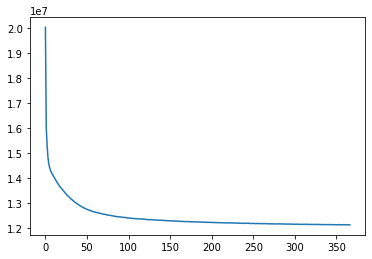

In [173]:
plt.plot(losses)

In [174]:
convert = lambda x:np.transpose(x, (1, 2, 0))

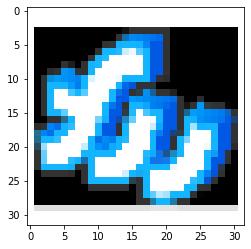

In [175]:
test_batch = next(iter(loader))
plt.imshow(convert(test_batch[1]))

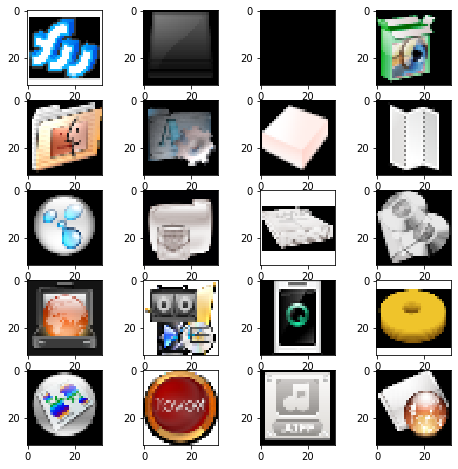

In [176]:
var = Variable(test_batch).cuda()
test_batch = test_batch.view(-1, 3, 32, 32)
res = model(var)

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(convert(test_batch[i]))
plt.show()

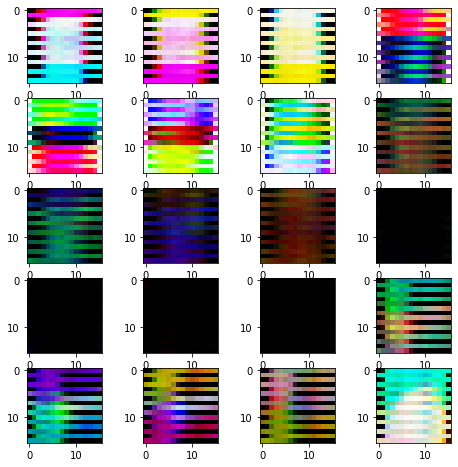

In [177]:
#.cpu().detach().numpy()
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(convert(res[0][i].cpu().detach().numpy()))
plt.show()

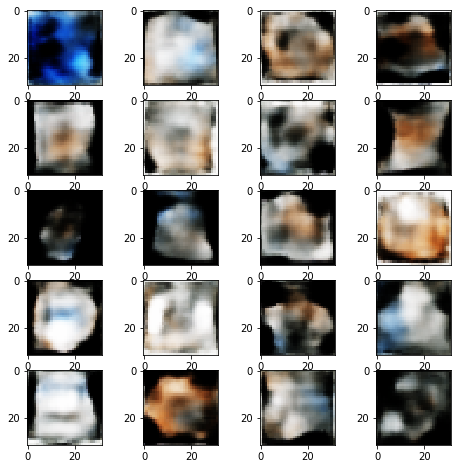

In [140]:
with torch.no_grad():
    sample = torch.randn(64, 768).cuda()
    sample = model.decode(sample).cpu()
    w=10
    h=10
    fig=plt.figure(figsize=(8, 8))
    columns = 4
    rows = 5
    for i in range(1, columns*rows +1):
        img = np.random.randint(10, size=(h,w))
        fig.add_subplot(rows, columns, i)
        plt.imshow(convert(sample[i]))
    plt.show()
    